# Chapter 2 – End-to-end Machine Learning project

# Vorbereitung


#### Dieses Noteboook wurde erstellt von Aurelien Geron. Es gehört zu dessen Buch "Hands-on Machine Learning with Scikit-learn,Keras and Tensorflow ". 
<p>Das Original-Notebook kann man finden unter https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb
<p>   Das Notebook wurde für Unterrichtszwecke verändert und kommentiert von Elisabeth Staegemann

In [1]:
#Angeben, unter welchen Systemvoraussetzungen das Notebook läuft

import sys
assert sys.version_info >= (3, 7)


import sklearn #"scikit-learn"
assert sklearn.__version__ >= "1.2"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

#### Schreibe eine Funktion zum einfachen Abspeichern von Bildern

In [2]:
# extra code – code to save the figures as high-res PNGs for the book
# erzeugt auch den images-Ordner, falls der nicht existiert

from pathlib import Path
import pickle

IMAGES_PATH = Path() / "images" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#### Schreibe eine Funktion für den einfachen Download

In [3]:
from pathlib import Path
import tarfile
import urllib.request

def load_housing_data(url,ordner_name,csv_name):
    ordner = Path(ordner_name)
    tarball_path = ordner / Path(url).name # der  Filename des Archivs
    #csv_file = ordner / Path(csv_name)    
   
    if not tarball_path.is_file():
        ordner.mkdir(parents=True, exist_ok=True)        
        urllib.request.urlretrieve(url, tarball_path)
        
    csv_file = ordner / "housing" / csv_name
    # der tarball erzeugt beim Auspacken den Ordnernamen "housing"
    # das muss man wissen
        
    if not csv_file.is_file():
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path=ordner.name)           
            
    return pd.read_csv(csv_file)
    
    

# <p>Überblick über die Daten
## Herunterladen

*Welcome to Machine Learning Housing Corp.! _____________________Your task is to predict median house values in Californian districts, given a number of features from these districts.*

In [4]:
housing_gesamt \
= load_housing_data(url="https://github.com/ageron/data/raw/main/housing.tgz", 
                    ordner_name="datasets", csv_name="housing.csv")
#print(type(housing_gesamt))

## Take a Quick Look at the Data Structure

In [6]:
housing_gesamt.tail(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20630,-121.32,39.29,11.0,2640.0,505.0,1257.0,445.0,3.5673,112000.0,INLAND
20631,-121.40,39.33,15.0,2655.0,493.0,1200.0,432.0,3.5179,107200.0,INLAND
20632,-121.45,39.26,15.0,2319.0,416.0,1047.0,385.0,3.1250,115600.0,INLAND
20633,-121.53,39.19,27.0,2080.0,412.0,1082.0,382.0,2.5495,98300.0,INLAND
20634,-121.56,39.27,28.0,2332.0,395.0,1041.0,344.0,3.7125,116800.0,INLAND
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND
20639,-121.24,39.37,16.0,2785.0,616.0,1387.0,530.0,2.3886,89400.0,INLAND


In [7]:
housing_gesamt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### Inhalte der Object-Spalte

In [8]:
# Was steht denn wohl in der Spalte, die den Typ "object" hat?
housing_gesamt["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

### Inhalte  der Numerischen Spalten

In [9]:
housing_gesamt.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Histogramme

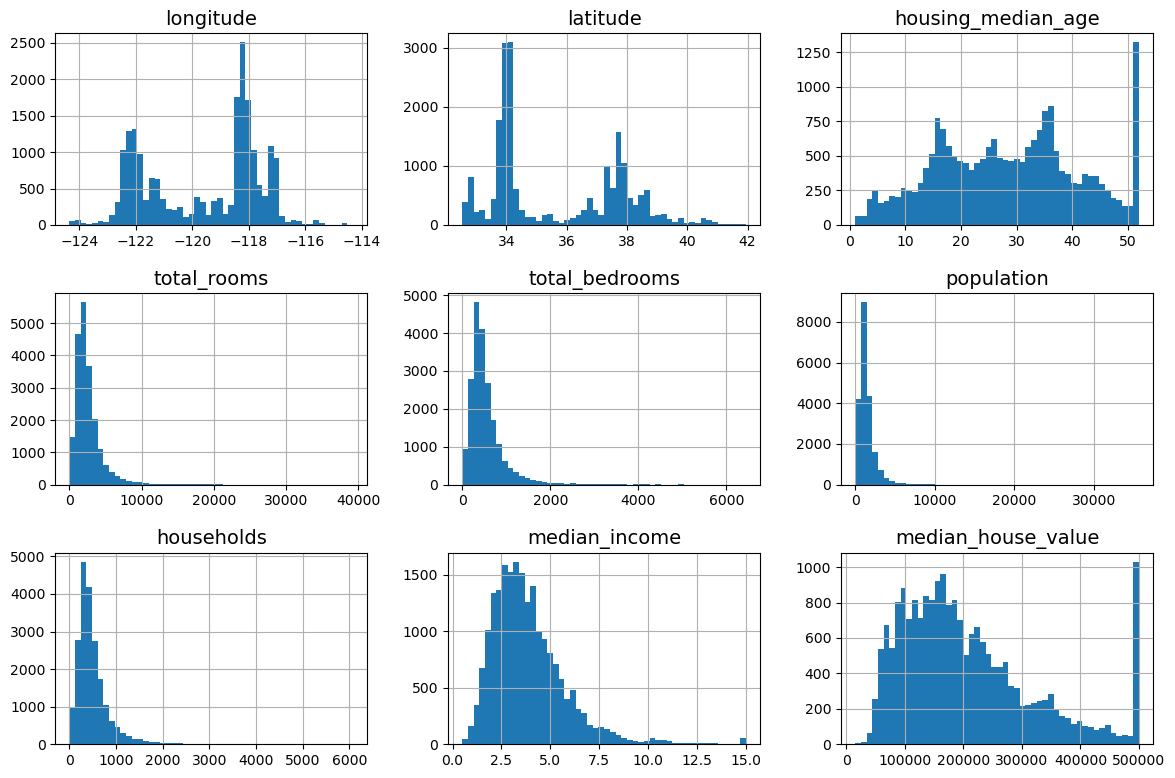

In [10]:
# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing_gesamt.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

### Auffällige Daten genauer untersuchen

In [11]:
datensatz_truncated = housing_gesamt[housing_gesamt["median_house_value"]>500000]
print("Die Anzahl der Zeilen und Spalten, wo der Preis > 500_000\n",
      datensatz_truncated.shape)


Die Anzahl der Zeilen und Spalten, wo der Preis > 500_000
 (965, 10)


In [12]:
datensatz_truncated.head(20)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
89,-122.27,37.80,52.0,249.0,78.0,396.0,85.0,1.2434,500001.0,NEAR BAY
103,-118.47,33.99,24.0,1438.0,454.0,665.0,416.0,2.9750,500001.0,<1H OCEAN
105,-118.50,33.97,29.0,2737.0,808.0,1157.0,696.0,5.1280,500001.0,<1H OCEAN
107,-118.39,34.08,27.0,6605.0,1710.0,2665.0,1520.0,3.8088,500001.0,<1H OCEAN
132,-122.34,37.55,44.0,2465.0,328.0,843.0,324.0,6.9533,500001.0,NEAR OCEAN
163,-122.27,37.54,15.0,2126.0,310.0,905.0,306.0,8.9083,500001.0,NEAR BAY
176,-117.67,33.47,22.0,2728.0,616.0,1081.0,566.0,1.6393,500001.0,<1H OCEAN
196,-122.14,37.44,52.0,3117.0,468.0,1114.0,421.0,6.6756,500001.0,NEAR BAY
294,-118.17,33.74,36.0,2006.0,453.0,807.0,426.0,3.7838,500001.0,NEAR OCEAN
306,-118.36,34.10,52.0,1096.0,247.0,423.0,230.0,3.0179,500001.0,<1H OCEAN


## Geografische Daten visualisieren

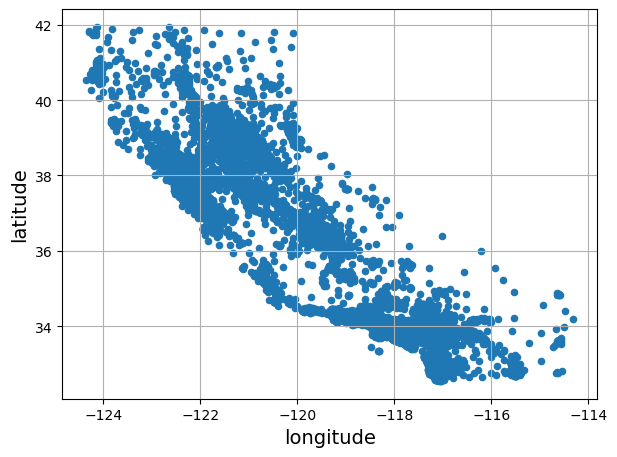

In [13]:
housing = housing_gesamt
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
save_fig("bad_visualization_plot")  # extra code
plt.show()

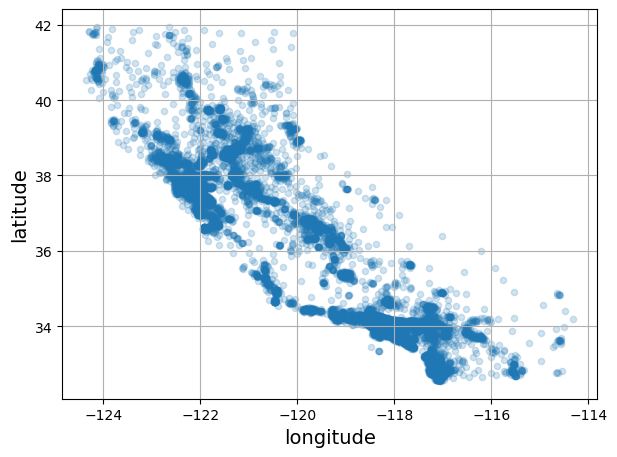

In [14]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
save_fig("better_visualization_plot")  # extra code
plt.show()

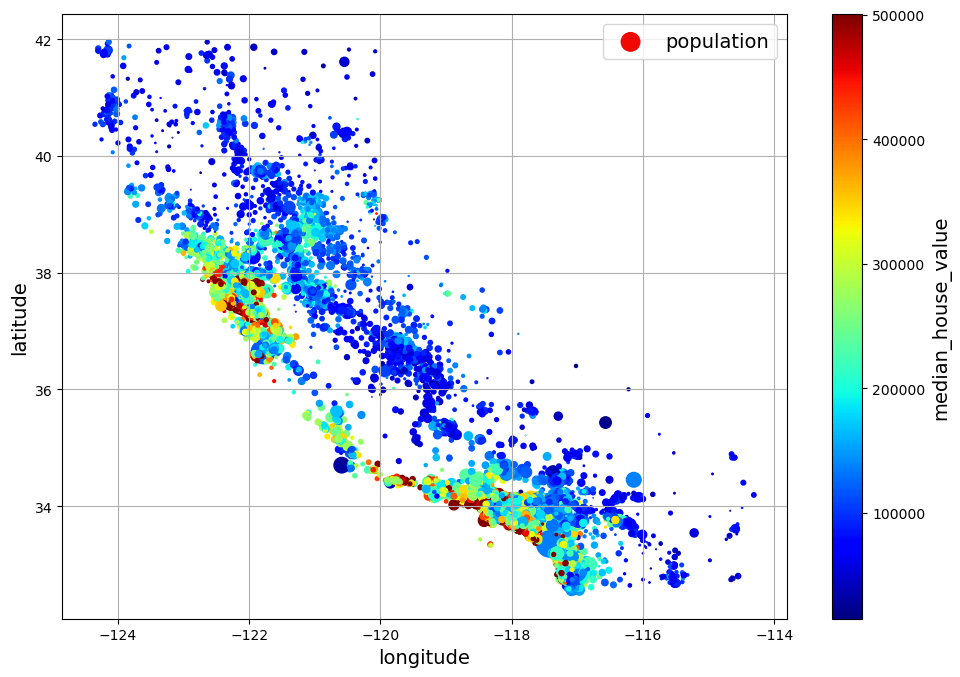

In [15]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"]/100 , label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, figsize=(10, 7)
             , sharex=False
            )
save_fig("housing_prices_scatterplot")  # extra code
plt.show()

The argument `sharex=False` fixes a display bug: without it, the x-axis values and label are not displayed (see: https://github.com/pandas-dev/pandas/issues/10611).

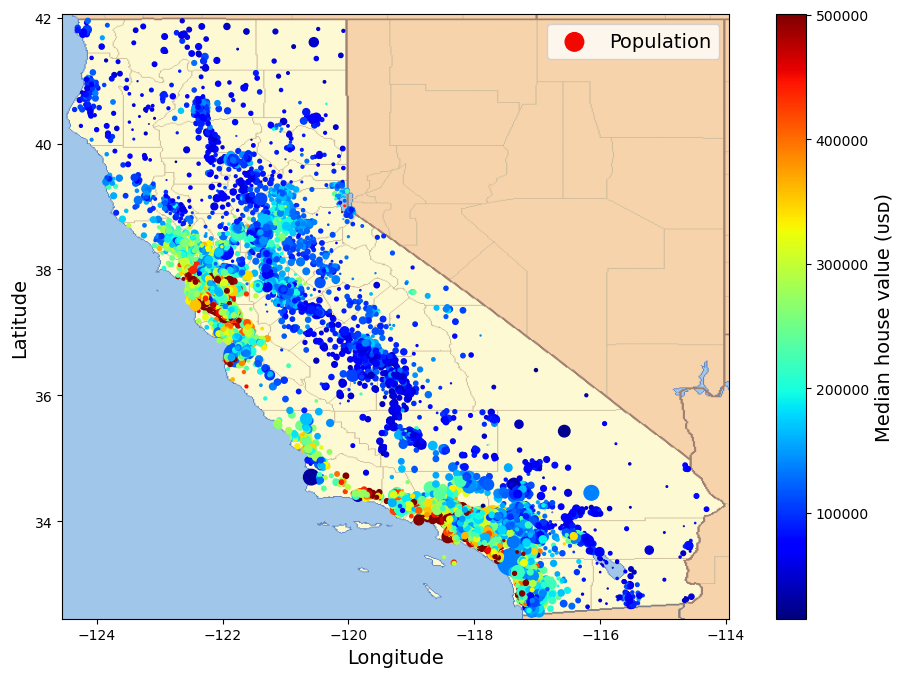

In [16]:
# extra code – this cell generates the first figure in the chapter

# Download the California image
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
#axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

save_fig("california_housing_prices_plot")
plt.show()

## Korrelationen anschauen

### Korrelationsberechnung
Beziehungen zwischen den Spalten feststellen

$r=\frac{\sum{(x-\bar{x})(y-\bar{y})}}{\sqrt{\sum{(x-\bar{x})^2}}*\sqrt{\sum (y-\bar{y})^2}}$

In [17]:
assert pd.__version__ >="1.5.0"
corr_matrix = housing.corr(numeric_only = True)
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


In [18]:
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [19]:
# Beziehungen zwischen 2 Spalten auf grafischem Weg ermitteln.

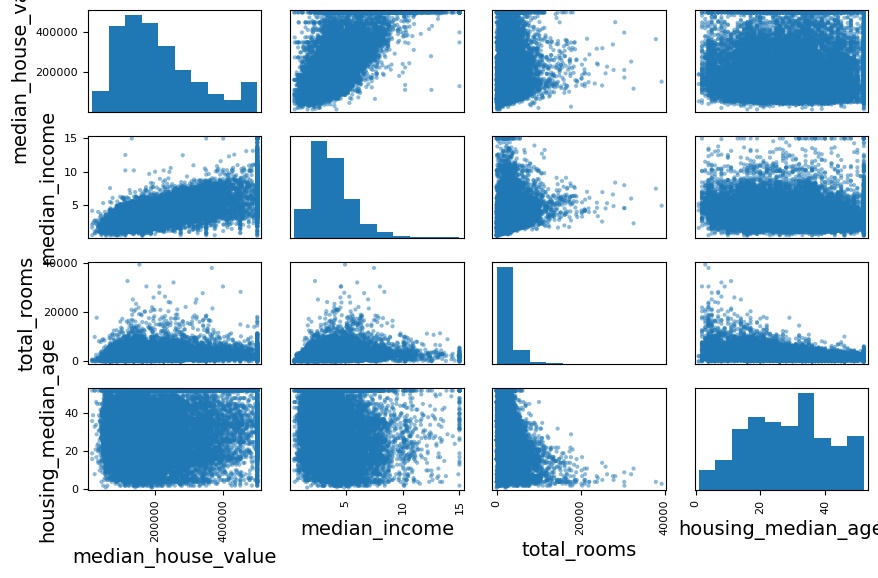

In [20]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(9, 6))
save_fig("scatter_matrix_plot")  # extra code
plt.show()

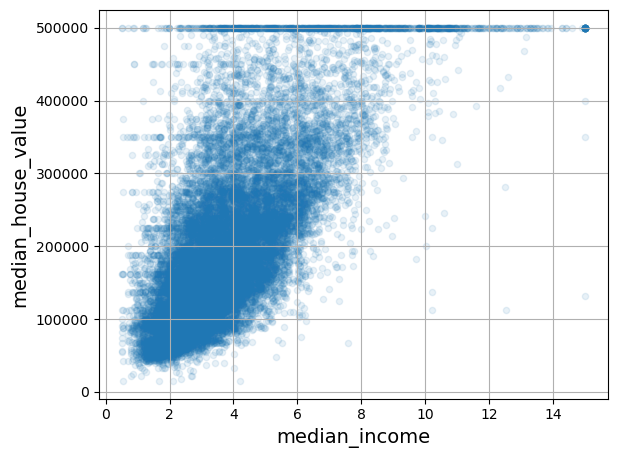

In [21]:
# genauer hinschauen
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
save_fig("income_vs_house_value_scatterplot")  # extra code
plt.show()

## Experimentieren mit Attribut-Kombinationen

In [22]:
# Vielleicht gibt bessere Korrelationen, wenn man aus den Daten zusätzliche Spalten berechnet ??

In [23]:
# Die Spalten "total_rooms","total_bedrooms",households" beziehen sich auf den jeweiligen Bezirk
# Die unten stehenden  Spalten sind sinnvoller 
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [24]:
corr_matrix = housing.corr(numeric_only=True)
corrspalte=corr_matrix["median_house_value"]
corr_sortiert=corrspalte.sort_values(ascending=False,key=np.abs)
corr_sortiert

median_house_value    1.000000
median_income         0.688075
bedrooms_ratio       -0.255880
rooms_per_house       0.151948
latitude             -0.144160
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
longitude            -0.045967
population           -0.024650
people_per_house     -0.023737
Name: median_house_value, dtype: float64